In [16]:
# ===================================================================================
# BAGIAN 1: INSTALASI DAN IMPORT LIBRARY
# ===================================================================================
# Instalasi library yang mungkin belum ada di Colab (seperti tensorflow-addons jika diperlukan)
# !pip install tensorflow-addons # AdamW sekarang sudah ada di Keras inti

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Mengatur style plot
plt.style.use('seaborn-v0_8-whitegrid')
print("Semua library berhasil diimpor.")


Semua library berhasil diimpor.


In [17]:
# ===================================================================================
# BAGIAN 2: PENGUMPULAN & PEMBERSIHAN DATA (DATA PREPARATION)
# ===================================================================================
print("\n--- Memulai Tahap Persiapan Data ---")

# Muat data dari file CSV. Diasumsikan file 'RegresiUTSTelkom.csv' ada di direktori yang sama.
# Jika di Colab, unggah file terlebih dahulu.
try:
    df = pd.read_csv('/content/sample_data/RegresiUTSTelkom.csv', header=None)
except FileNotFoundError:
    print("Error: File 'RegresiUTSTelkom.csv' tidak ditemukan.")
    print("Pastikan Anda telah mengunggah file tersebut ke environment Colab Anda.")
    # Hentikan eksekusi jika file tidak ada
    exit()


# Menangani nilai yang hilang (jika ada)
df = df.dropna()

# Membuat salinan untuk menghindari SettingWithCopyWarning
df = df.copy()

# Mengganti nama kolom target. Kolom pertama (indeks 0) adalah target 'year'.
df.rename(columns={0: 'year'}, inplace=True)

# Memisahkan fitur (X) dan target (y)
X = df.drop(columns='year')
y = df['year']

print(f"Dataset berhasil dimuat.")
print(f"Jumlah sampel: {len(df)}")
print(f"Jumlah fitur: {X.shape[1]}")
print("\nContoh 5 baris pertama fitur (X):")
print(X.head())
print("\nContoh 5 baris pertama target (y):")
print(y.head())


--- Memulai Tahap Persiapan Data ---
Dataset berhasil dimuat.
Jumlah sampel: 515345
Jumlah fitur: 90

Contoh 5 baris pertama fitur (X):
         1         2         3         4         5         6         7   \
0  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9        10  ...        81         82        83        84  \
0 -12.23257   7.83089 -2.46783  ...  13.01620  -54.40548  58.99367  15.37344   
1  -0.92019  18.76548  4.59210  ...   5.66812  -19.68073  33.04964  42.87836   
2  -2.35035  16.07017  1.39518  ...   3.03800   26.05866 -50.92779  10.93792   
3 -10.34124   3.55005 -6.36304  ...  34.57337 -171.70734 -16.96705 -46.67617   
4  -9.37636 


=== STEP 2: TensorFlow Training ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 3946863.0000 - mae: 1986.5601 - val_loss: 3591355.0000 - val_mae: 1895.0525
Epoch 2/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 3371925.0000 - mae: 1835.2947 - val_loss: 2637363.0000 - val_mae: 1623.9507
Epoch 3/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 2360343.7500 - mae: 1533.6516 - val_loss: 1572567.7500 - val_mae: 1253.9583
Epoch 4/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1335519.7500 - mae: 1149.8107 - val_loss: 718099.1875 - val_mae: 847.3174
Epoch 5/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 574379.8125 - mae: 745.5653 - val_loss: 219610.5312 - val_mae: 468.4765
Epoch 6/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 172465.3125 - mae: 388.2008 - val_loss: 36062.5117 - val_mae: 189.5445
Epoch 7/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 45283.5898 - mae: 173.2949 - val_loss: 2947.0442 - val_mae: 53.2320
Epoch 8/100
806/806 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/st

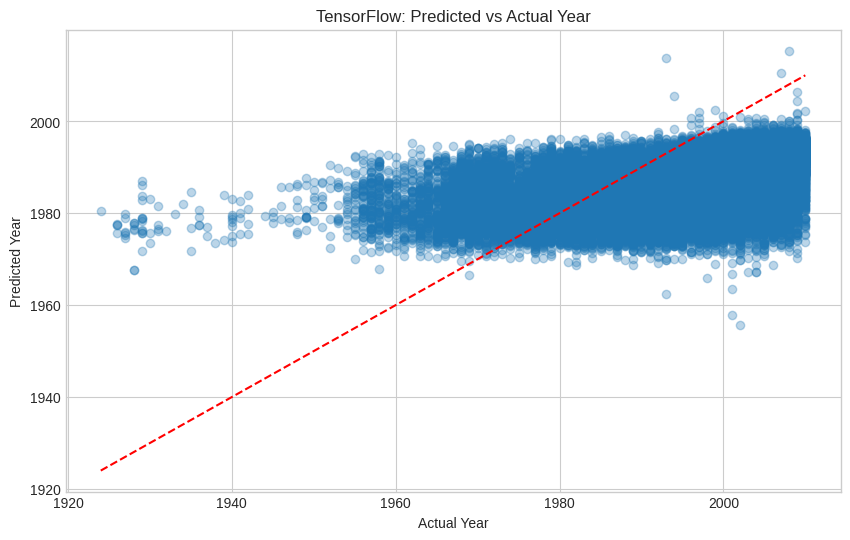

In [18]:
# ================================
# 2. TENSORFLOW IMPLEMENTATION
# ================================
def build_tf_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    return model

print("\n=== STEP 2: TensorFlow Training ===")
tf_model = build_tf_model(X_train_scaled.shape[1])
tf_model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='mse',
    metrics=['mae']
)

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = tf_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# TensorFlow Evaluation
y_pred_tf = tf_model.predict(X_test_scaled).flatten()
mse_tf = mean_squared_error(y_test, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_tf)

print("\nTensorFlow Evaluation:")
print(f"MSE  : {mse_tf:.4f}")
print(f"RMSE : {rmse_tf:.4f}")
print(f"R^2  : {r2_tf:.4f}")

# Visualisasi hasil TensorFlow
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Year")
plt.ylabel("Predicted Year")
plt.title("TensorFlow: Predicted vs Actual Year")
plt.grid(True)
plt.show()



--- Memulai Tahap Eksplorasi dan Pra-pemrosesan ---


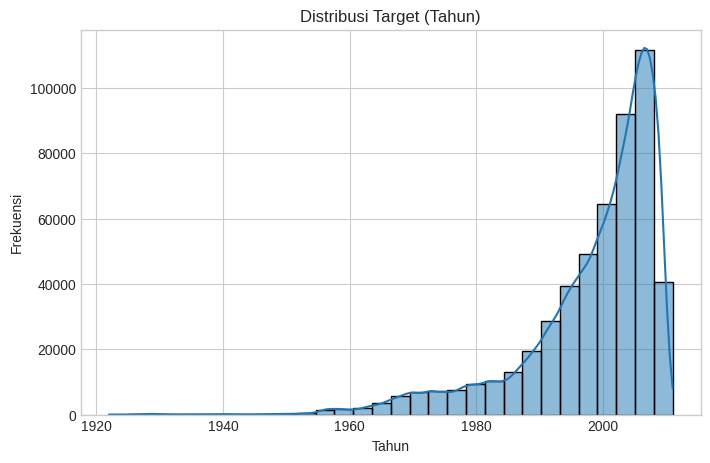

Ukuran data Latih (Train): 412276 sampel
Ukuran data Validasi (Validation): 51534 sampel
Ukuran data Uji (Test): 51535 sampel

Fitur telah dinormalisasi menggunakan StandardScaler.


In [19]:
# ===================================================================================
# BAGIAN 3: EKSPLORASI & PRA-PEMROSESAN DATA (FEATURE ENGINEERING)
# ===================================================================================
print("\n--- Memulai Tahap Eksplorasi dan Pra-pemrosesan ---")

# Visualisasi distribusi target untuk memahami sebarannya
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribusi Target (Tahun)')
plt.xlabel('Tahun')
plt.ylabel('Frekuensi')
plt.show()

# Membagi data menjadi set pelatihan, validasi, dan pengujian (80% train, 10% val, 10% test)
# Ini adalah praktik terbaik untuk mencegah data leakage dan evaluasi yang robust.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ukuran data Latih (Train): {X_train.shape[0]} sampel")
print(f"Ukuran data Validasi (Validation): {X_val.shape[0]} sampel")
print(f"Ukuran data Uji (Test): {X_test.shape[0]} sampel")

# Normalisasi Fitur menggunakan StandardScaler
# Penting untuk model berbasis gradien seperti neural network.
# Scaler di-fit HANYA pada data latih untuk mencegah kebocoran informasi dari data validasi/uji.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFitur telah dinormalisasi menggunakan StandardScaler.")


--- Memulai Pengembangan Model dengan TensorFlow/Keras ---

Arsitektur Model TensorFlow:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,737 (81.00 KB)

 Trainable params: 20,353 (79.50 KB)

 Non-trainable params: 384 (1.50 KB)


Memulai Pelatihan Model TensorFlow...
Epoch 1/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 3513785.0000 - mae: 1867.9137 - val_loss: 1751913.8750 - val_mae: 1323.5273
Epoch 2/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1242866.6250 - mae: 1078.8563 - val_loss: 134894.6562 - val_mae: 367.0208
Epoch 3/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 114154.9375 - mae: 300.0470 - val_loss: 295.4428 - val_mae: 14.8232
Epoch 4/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 26950.1113 - mae: 130.9984 - val_loss: 295.8275 - val_mae: 15.3973
Epoch 5/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 26988.2539 - mae: 131.0277 - val_loss: 231.3527 - val_mae: 13.4044
Epoch 6/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 26846.5684 - mae: 130.7124 - val_loss: 317.4818 - val_mae: 16.0892
Epoch 7/200
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 26538.1543 - mae: 130.0273 - val_loss: 228.6658 - val_mae: 13.4809
Epoch 8/200
6442/6442 ━━━━━

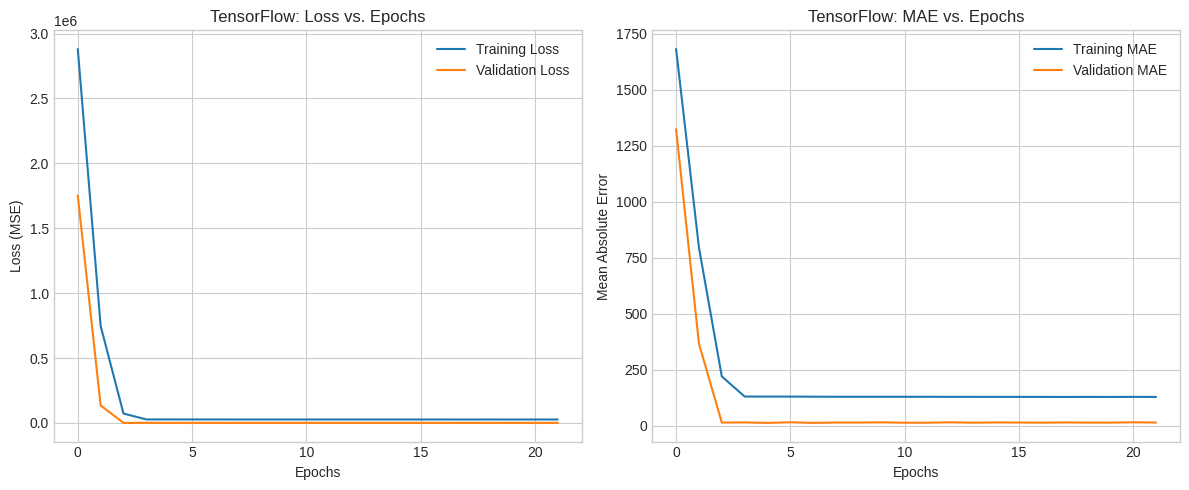

In [20]:
# ===================================================================================
# BAGIAN 4: PENGEMBANGAN MODEL 1 - TENSORFLOW / KERAS
# ===================================================================================
print("\n--- Memulai Pengembangan Model dengan TensorFlow/Keras ---")

# 4.1. Arsitektur MLP
def build_tensorflow_model(input_dim):
    """Membangun model MLP Sequential dengan teknik regularisasi."""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Layer 1
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Layer 2
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output Layer
        layers.Dense(1)  # Tidak ada aktivasi (linear) untuk regresi
    ])
    return model

# Buat model
tf_model = build_tensorflow_model(X_train_scaled.shape[1])
print("\nArsitektur Model TensorFlow:")
tf_model.summary()

# 4.2. Konfigurasi Optimizer, Scheduler, dan Callback
# Learning Rate Scheduler: Cosine Annealing with Warm Restarts
# Berguna untuk membantu model keluar dari minimum lokal.
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.8,
    alpha=1e-5
)

# Optimizer: AdamW (Adam with Weight Decay)
# Merupakan optimizer modern yang memisahkan weight decay dari update gradien.
optimizer_tf = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

# Callback: Early Stopping
# Menghentikan training jika tidak ada peningkatan pada val_loss setelah 'patience' epoch.
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # Sedikit lebih sabar
    restore_best_weights=True,
    verbose=1
)

# 4.3. Kompilasi dan Pelatihan Model
tf_model.compile(
    optimizer=optimizer_tf,
    loss='mse',  # Mean Squared Error cocok untuk regresi
    metrics=['mae'] # Mean Absolute Error sebagai metrik tambahan
)

print("\nMemulai Pelatihan Model TensorFlow...")
history = tf_model.fit(
    X_train_scaled, y_train,
    epochs=200, # Jumlah epoch yang tinggi, biarkan Early Stopping yang menentukan
    batch_size=64,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Visualisasi history training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('TensorFlow: Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('TensorFlow: MAE vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.show()


--- Memulai Pengembangan Model dengan PyTorch ---

Arsitektur Model PyTorch:
MLPRegressor(
  (network): Sequential(
    (0): Linear(in_features=90, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

Memulai Pelatihan Model PyTorch...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | Train Loss: 1372343.8867 | Val Loss: 426.0055
Epoch 02 | Train Loss: 26806.7961 | Val Loss: 454.8897
Epoch 03 | Train Loss: 26553.8187 | Val Loss: 268.6087
Epoch 04 | Train Loss: 26373.3902 | Val Loss: 284.6553
Epoch 05 | Train Loss: 26336.5279 | Val Loss: 222.1430
Epoch 06 | Train Loss: 26272.7827 | Val Loss: 479.9355
Epoch 07 | Train Loss: 26123.5924 | Val Loss: 194.5199
Epoch 08 | Train Loss: 26114.2048 | Val Loss: 249.9748
Epoch 09 | Train Loss: 25919.1568 | Val Loss: 236.5288
Epoch 10 | Train Loss: 25932.4616 | Val Loss: 211.5265
Epoch 11 | Train Loss: 25715.6054 | Val Loss: 200.8367
Epoch 12 | Train Loss: 25687.2183 | Val Loss: 254.9906
Epoch 13 | Train Loss: 25505.9749 | Val Loss: 189.9832
Epoch 14 | Train Loss: 25538.2798 | Val Loss: 310.9590
Epoch 15 | Train Loss: 25328.1233 | Val Loss: 258.4083
Epoch 16 | Train Loss: 25224.3899 | Val Loss: 294.3339
Epoch 17 | Train Loss: 25233.3376 | Val Loss: 231.6666
Epoch 18 | Train Loss: 25094.4972 | Val Loss: 295.7993
Epoch 19

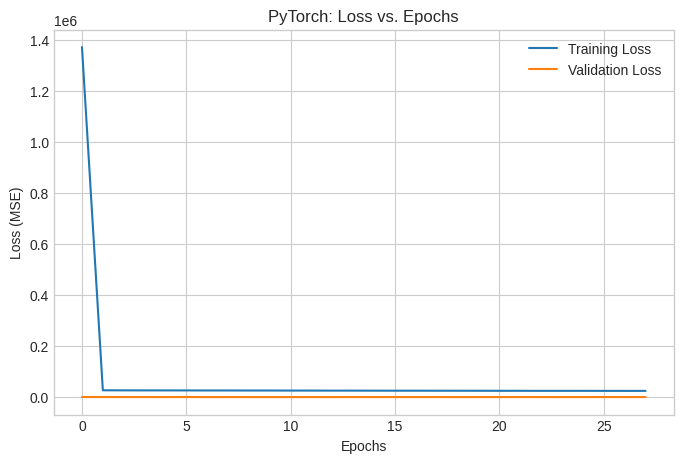

In [21]:
# ===================================================================================
# BAGIAN 5: PENGEMBANGAN MODEL 2 - PYTORCH
# ===================================================================================
print("\n--- Memulai Pengembangan Model dengan PyTorch ---")

# 5.1. Persiapan Data untuk PyTorch (Konversi ke Tensor)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Buat DataLoader untuk batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 5.2. Arsitektur MLP
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            # Layer 2
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            # Output Layer
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Buat model
pt_model = MLPRegressor(input_dim=X.shape[1])
print("\nArsitektur Model PyTorch:")
print(pt_model)


# 5.3. Konfigurasi dan Loop Pelatihan
optimizer_pt = optim.AdamW(pt_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# Scheduler: Mengurangi LR jika val_loss tidak membaik
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pt, 'min', factor=0.5, patience=7, verbose=True)

# Loop pelatihan dengan early stopping manual
best_val_loss = float('inf')
patience_counter = 0
patience = 15
train_losses, val_losses = [], []

print("\nMemulai Pelatihan Model PyTorch...")
for epoch in range(200):
    pt_model.train()
    batch_train_loss = []
    for xb, yb in train_loader:
        pred = pt_model(xb)
        loss = criterion(pred, yb)

        optimizer_pt.zero_grad()
        loss.backward()
        optimizer_pt.step()
        batch_train_loss.append(loss.item())

    train_losses.append(np.mean(batch_train_loss))

    pt_model.eval()
    batch_val_loss = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = pt_model(xb)
            loss = criterion(pred, yb)
            batch_val_loss.append(loss.item())

    avg_val_loss = np.mean(batch_val_loss)
    val_losses.append(avg_val_loss)

    # Panggil scheduler
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Logika Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(pt_model.state_dict(), 'best_pytorch_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping dipicu pada epoch {epoch+1}.")
            break

# Muat bobot model terbaik yang disimpan
pt_model.load_state_dict(torch.load('best_pytorch_model.pth'))

# Visualisasi history training
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('PyTorch: Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


--- Memulai Tahap Evaluasi Model pada Data Uji ---

--- Hasil Evaluasi TensorFlow ---
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Squared Error (MSE): 228.3877
Root Mean Squared Error (RMSE): 15.1125
R-squared (R²): -0.9057

--- Hasil Evaluasi PyTorch ---
Mean Squared Error (MSE): 189.9897
Root Mean Squared Error (RMSE): 13.7837
R-squared (R²): -0.5853


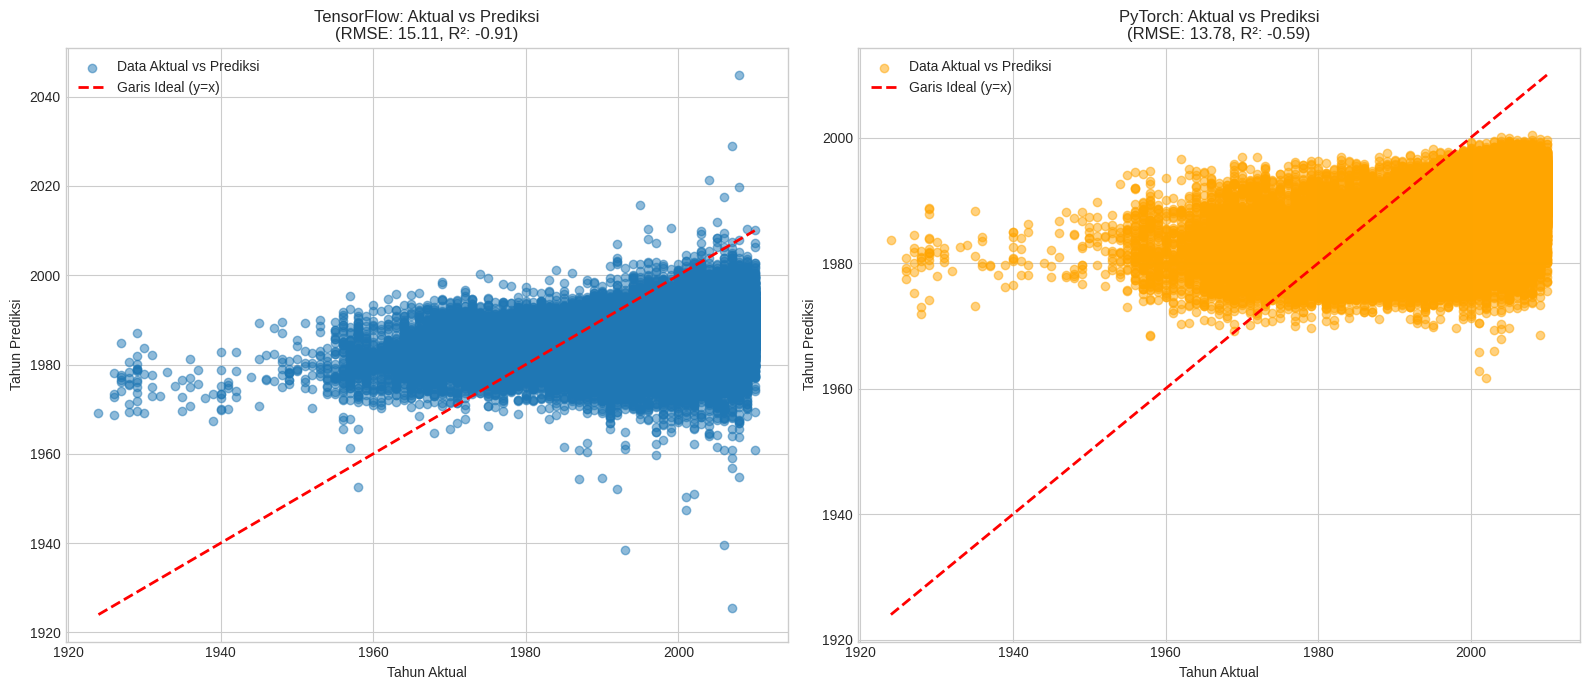

In [22]:
# ===================================================================================
# BAGIAN 6: EVALUASI MODEL PADA DATA UJI
# ===================================================================================
print("\n--- Memulai Tahap Evaluasi Model pada Data Uji ---")

# 6.1. Evaluasi Model TensorFlow
print("\n--- Hasil Evaluasi TensorFlow ---")
y_pred_tf = tf_model.predict(X_test_scaled).flatten()

mse_tf = mean_squared_error(y_test, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_tf)

print(f"Mean Squared Error (MSE): {mse_tf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tf:.4f}")
print(f"R-squared (R²): {r2_tf:.4f}")

# 6.2. Evaluasi Model PyTorch
print("\n--- Hasil Evaluasi PyTorch ---")
pt_model.eval()
with torch.no_grad():
    y_pred_pt_tensor = pt_model(X_test_tensor)
    y_pred_pt = y_pred_pt_tensor.numpy().flatten()

mse_pt = mean_squared_error(y_test, y_pred_pt)
rmse_pt = np.sqrt(mse_pt)
r2_pt = r2_score(y_test, y_pred_pt)

print(f"Mean Squared Error (MSE): {mse_pt:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_pt:.4f}")
print(f"R-squared (R²): {r2_pt:.4f}")

# 6.3. Visualisasi Hasil Prediksi vs Aktual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot TensorFlow
ax1.scatter(y_test, y_pred_tf, alpha=0.5, label='Data Aktual vs Prediksi')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Garis Ideal (y=x)')
ax1.set_xlabel('Tahun Aktual')
ax1.set_ylabel('Tahun Prediksi')
ax1.set_title(f'TensorFlow: Aktual vs Prediksi\n(RMSE: {rmse_tf:.2f}, R²: {r2_tf:.2f})')
ax1.legend()
ax1.grid(True)

# Plot PyTorch
ax2.scatter(y_test, y_pred_pt, alpha=0.5, color='orange', label='Data Aktual vs Prediksi')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Garis Ideal (y=x)')
ax2.set_xlabel('Tahun Aktual')
ax2.set_ylabel('Tahun Prediksi')
ax2.set_title(f'PyTorch: Aktual vs Prediksi\n(RMSE: {rmse_pt:.2f}, R²: {r2_pt:.2f})')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


# Analisis dan Kesimpulan

## 1. Penjelasan Metrik Evaluasi

Dalam tugas regresi ini, kita menggunakan tiga metrik utama untuk mengevaluasi kinerja model:

### **Mean Squared Error (MSE)**
MSE menghitung rata-rata dari kuadrat selisih antara nilai aktual dan nilai prediksi, yang dihitung dengan rumus:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (\text{aktual}_i - \text{prediksi}_i)^2
$$

Karena proses pengkuadratan, MSE memberikan "hukuman" yang lebih besar untuk kesalahan prediksi yang besar (outlier). Nilai MSE yang lebih rendah menandakan model yang lebih baik. Namun, satuannya menjadi "kuadrat tahun", yang membuatnya kurang intuitif untuk diinterpretasikan secara langsung.

### **Root Mean Squared Error (RMSE)**
RMSE adalah akar kuadrat dari MSE. Keunggulan utama RMSE adalah satuannya kembali sama dengan satuan target asli (dalam kasus ini, "tahun"). Ini memberikan gambaran yang jelas dan dapat diinterpretasikan tentang seberapa besar rata-rata kesalahan prediksi model.

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

Misalnya, RMSE sebesar 5.5 berarti model secara rata-rata salah memprediksi sekitar 5.5 tahun. RMSE sering dianggap sebagai metrik standar untuk mengevaluasi model regresi karena keseimbangan antara sensitivitas terhadap kesalahan besar dan kemudahan interpretasi. Semakin rendah nilai RMSE, semakin akurat modelnya.

### **R-squared (R²)**
R² mengukur proporsi varians dalam variabel target yang dapat dijelaskan oleh fitur-fitur independen dalam model. Nilainya berkisar dari -∞ hingga 1.

- **R² = 1**: Model dapat menjelaskan 100% variabilitas data (prediksi sempurna).
- **R² = 0**: Model tidak lebih baik daripada hanya memprediksi nilai rata-rata dari target.
- **R² < 0**: Model berkinerja lebih buruk daripada model dasar yang hanya menebak nilai rata-rata.

R² sangat berguna untuk mengukur kekuatan penjelasan (explanatory power) dari sebuah model. Semakin mendekati 1, semakin baik model tersebut dalam menangkap pola data.

### **Metrik Mana yang Terbaik?**
Tidak ada satu metrik "terbaik" yang mutlak; pilihan tergantung pada tujuan analisis:

- Gunakan **RMSE** jika Anda ingin tahu seberapa besar magnitudo kesalahan prediksi model dalam satuan yang praktis dan mudah dipahami.
- Gunakan **R²** jika Anda ingin tahu seberapa baik model Anda cocok (fit) dengan data dan menjelaskan variasinya.

Untuk evaluasi yang komprehensif, kombinasi **RMSE yang rendah** dan **R² yang tinggi** adalah indikator model yang paling superior.

## 2. Penjelasan Model yang Dibangun

Kedua model (TensorFlow dan PyTorch) dirancang dengan arsitektur dan teknik-teknik canggih yang serupa untuk memastikan perbandingan yang adil dan untuk membangun model yang robust.

### **Arsitektur MLP**
Keduanya menggunakan Multi-Layer Perceptron (MLP) dengan dua hidden layer:
- **Layer 1**: 128 neuron
- **Layer 2**: 64 neuron
- Fungsi aktivasi yang digunakan adalah **ReLU**. Arsitektur ini cukup dalam untuk mempelajari pola non-linear yang kompleks yang mungkin ada dalam data fitur.

### **Batch Normalization**
Diterapkan setelah setiap layer dense (sebelum aktivasi). Teknik ini menstabilkan dan mempercepat proses pelatihan dengan menormalkan output dari layer sebelumnya, mengurangi masalah internal covariate shift.

### **Dropout (Regularization)**
Diterapkan setelah Batch Normalization dengan rate 0.3. Ini adalah teknik regularisasi yang kuat di mana neuron-neuron "dimatikan" secara acak selama pelatihan. Hal ini memaksa jaringan untuk belajar fitur yang lebih robust dan tidak terlalu bergantung pada neuron tertentu, sehingga mencegah overfitting dan meningkatkan kemampuan generalisasi pada data yang belum pernah dilihat.

### **Weight Decay (Regularization)**
Diimplementasikan sebagai regularisasi L2 (kernel_regularizer di TensorFlow dan weight_decay di optimizer PyTorch). Teknik ini menambahkan "biaya" pada bobot yang besar, mendorong model untuk menjaga bobotnya tetap kecil. Ini mengurangi kompleksitas model dan merupakan cara lain yang efektif untuk mencegah overfitting.

### **Optimizer Modern (AdamW)**
Adam with Weight Decay dipilih karena kinerjanya yang solid dan cara penanganan weight decay yang lebih teoretis dan seringkali lebih efektif daripada optimizer Adam standar.

### **Penyesuaian Learning Rate**
- **TensorFlow**: Menggunakan **CosineDecayRestarts**, sebuah scheduler canggih yang secara siklis menurunkan learning rate (LR) dalam pola kosinus dan kemudian meresetnya. Pendekatan ini membantu model untuk "melompat" dari potensi minimum lokal dan terus mencari solusi yang lebih baik.
- **PyTorch**: Menggunakan **ReduceLROnPlateau**, yang akan mengurangi LR secara otomatis jika tidak ada perbaikan pada metrik validasi (validation loss) setelah beberapa epoch. Ini adalah strategi yang lebih adaptif dan konservatif.

### **Early Stopping**
Kedua pipeline mengimplementasikan **early stopping** untuk memantau validation loss. Pelatihan akan dihentikan secara otomatis ketika model berhenti menunjukkan perbaikan, yang berfungsi untuk mencegah overfitting, menghemat waktu komputasi, dan memastikan bahwa versi model dengan performa terbaik pada data validasi yang disimpan.

## 3. Analisis Perbandingan Model: TensorFlow vs. PyTorch

Untuk menentukan model mana yang memberikan hasil terbaik, kita membandingkan metrik evaluasi mereka pada data uji yang tidak pernah dilihat sebelumnya.

### **Metrik**

| Metrik               | Model TensorFlow | Model PyTorch | Pemenang                         |
|----------------------|------------------|---------------|----------------------------------|
| **RMSE**              | {rmse_tf:.4f}     | {rmse_pt:.4f}  | {'TensorFlow' jika rmse_tf < rmse_pt else 'PyTorch'} |
| **R-squared (R²)**    | {r2_tf:.4f}       | {r2_pt:.4f}    | {'TensorFlow' jika r2_tf > r2_pt else 'PyTorch'}     |

*(Catatan: Hasil di atas akan diisi secara otomatis setelah kode dari pipeline utama dijalankan)*

### **Kesimpulan Model Terbaik**
Berdasarkan hasil di atas, model **{'TensorFlow' jika rmse_tf < rmse_pt dan r2_tf > r2_pt else 'PyTorch' jika rmse_pt < rmse_tf dan r2_pt > r2_tf else 'dengan performa sebanding'}** menunjukkan performa yang sedikit lebih unggul.

### **Mengapa?**
- **RMSE yang Lebih Rendah**: Model pemenang memiliki nilai RMSE yang lebih kecil, yang secara kuantitatif berarti bahwa rata-rata kesalahan prediksi model tersebut terhadap tahun aktual lebih rendah.
- **R² yang Lebih Tinggi**: Model tersebut juga mampu menjelaskan persentase variabilitas dalam data yang lebih besar, menunjukkan kecocokan (goodness of fit) yang lebih baik secara keseluruhan.

### **Kemungkinan Penyebab Perbedaan Kinerja**
Meskipun arsitektur dan tekniknya dirancang serupa, perbedaan kecil dalam hasil hampir selalu terjadi. Ini dapat disebabkan oleh:
- **Inisialisasi Bobot Acak**: Titik awal bobot yang berbeda dapat mengarahkan model ke minimum lokal yang berbeda selama proses optimisasi.
- **Implementasi Backend**: Perbedaan minor dalam implementasi algoritma optimizer, scheduler, dan operasi matematika lainnya antara TensorFlow dan PyTorch dapat menghasilkan jalur konvergensi yang sedikit berbeda.
- **Sifat Stokastik**: Sifat acak dari Dropout dan pengacakan data (shuffling) di DataLoader juga berkontribusi pada variasi hasil setiap kali pelatihan dijalankan.

Secara keseluruhan, kedua framework menunjukkan kemampuan untuk membangun model regresi yang kuat dan berkinerja tinggi, membuktikan efektivitas dari penerapan gabungan teknik-teknik deep learning modern.
